Задание №1. Реализуйте автоэнкодер для колоризации чёрно-белых изображений

In [166]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [219]:
# Поток загрузки картинок и генерации их вариаций
from keras.preprocessing.image import ImageDataGenerator

# Вывод всех путей картинок для расчета количества батчей на эпоху
from imutils.paths import list_images

# Загрузка картинок в формате PIL
from tensorflow.keras.utils import img_to_array, load_img

# Перевод картинок в другой формат
from skimage.color import rgb2lab, lab2rgb, gray2rgb, rgb2gray

# Используемая предобученная модель
from tensorflow.keras.applications import VGG16

# Слои для проектирования своей модели
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.optimizers import Adamax

# Операции над картинками
import cv2
import os

# Отображение графиков
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# NumPy
import numpy as np

In [220]:
seed = 24
batch_size = 100

colored_images = 'datasets/celeba_hq/train/male'
source_img_path = 'datasets/gray'
target_img_path = 'datasets/color'

os.makedirs(f"{source_img_path}/male", exist_ok=True)
os.makedirs(f"{target_img_path}/male", exist_ok=True)

for image in list_images(colored_images):
    img = cv2.imread(image)
    img = cv2.resize(img, (224, 224))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    cv2.imwrite(os.path.join(source_img_path, 'male', os.path.basename(image)), img_gray)
    cv2.imwrite(os.path.join(target_img_path, 'male', os.path.basename(image)), img)

In [221]:
encoder = VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
encoder.trainable = False
encoder.summary()

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((4, 4)))
autoencoder.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((4, 4)))
autoencoder.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
autoencoder.add(UpSampling2D((2, 2)))

autoencoder.summary()
autoencoder.compile(optimizer=Adamax(0.001), loss='mse', metrics=['accuracy'])

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [222]:
def preprocess_data(image, target):
    lab = rgb2lab(image)
    X = lab[:,:,:,0]
    Y = lab[:,:,:,1:]
    
    X = gray2rgb(X)
    
    X = np.array(X) / 256.0
    Y = np.array(Y) / 196.0
    
    return (X, Y)

In [223]:
def rgb_to_lab2ch(color_image):
    lab = rgb2lab(color_image)
    lab2ch = lab[:,:,1:]
    
    return lab2ch

In [224]:
def lab2ch_to_rgb(grayscale_image, ab):
    lab = rgb2lab(grayscale_image)
    l = lab[:,:,0]
    
    restored_lab_img = np.zeros((224, 224, 3))
    
    restored_lab_img[:,:,0] = l
    restored_lab_img[:,:,1:] = ab
    
    restored_color_img = lab2rgb(restored_lab_img)
    
    return restored_color_img


In [228]:
def trainGenerator(train_img_path, train_target_path):   
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        color_mode='rgb',
        target_size=(224, 224),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    target_datagen = ImageDataGenerator(**img_data_gen_args)
    target_generator = target_datagen.flow_from_directory(
        train_target_path,
        color_mode='grayscale',
        target_size=(224, 224),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, target_generator)
    
    for (img, target) in train_generator:
        processed_img, processed_target = preprocess_data(img, target)
        yield (processed_img, processed_target)

In [229]:
trainGen = trainGenerator(
    source_img_path,
    target_img_path
)

batch_count = len(list(list_images(source_img_path))) // batch_size
print(f'Batches per epoch: {batch_count}')

Batches per epoch: 45


In [230]:
history = autoencoder.fit(
    trainGen,
    steps_per_epoch=batch_count,
    batch_size=batch_size,
    epochs=25,
)

Found 4500 images belonging to 1 classes.


Found 4500 images belonging to 1 classes.
Epoch 1/25
45/45 [==============================] - 41s 922ms/step - loss: 0.0631 - accuracy: 0.5344
Epoch 2/25
45/45 [==============================] - 42s 925ms/step - loss: 3.9653e-06 - accuracy: 0.6258
Epoch 3/25
45/45 [==============================] - 41s 920ms/step - loss: 2.0960e-06 - accuracy: 0.7189
Epoch 4/25
45/45 [==============================] - 41s 920ms/step - loss: 1.3410e-06 - accuracy: 0.8067
Epoch 5/25
45/45 [==============================] - 42s 923ms/step - loss: 8.9074e-07 - accuracy: 0.8916
Epoch 6/25
45/45 [==============================] - 41s 922ms/step - loss: 6.1022e-07 - accuracy: 0.9371
Epoch 7/25
45/45 [==============================] - 41s 921ms/step - loss: 4.6821e-07 - accuracy: 0.9527
Epoch 8/25
45/45 [==============================] - 42s 932ms/step - loss: 3.9729e-07 - accuracy: 0.9584
Epoch 9/25
45/45 [==============================] - 42s 924ms/step - loss: 3.5592e-07 - accuracy: 0.9617
Epoch 10/25
45/45

In [231]:
autoencoder.save('models/colorization.h5')

In [232]:
from keras import models
autoencoder = models.load_model('models/colorization.h5')

In [233]:
from skimage.transform import resize
from skimage.color import rgb2lab, lab2rgb, gray2rgb, rgb2gray
from tensorflow.keras.applications.vgg16 import preprocess_input

def predict(imagePath):
    orig = img_to_array(load_img(imagePath))
    test = orig.copy()
    test = cv2.resize(test, (224,224))
    test *= 1.0/255
    lab = rgb2lab(test)
    l = lab[:,:,0]
    L = gray2rgb(l)
    L = L.reshape((1,224,224,3))
    L = preprocess_input(L)
    ab = autoencoder.predict(L)

    ab = ab*128
    cur = np.zeros((224, 224, 3))
    cur[:,:,0] = l
    cur[:,:,1:] = ab
    
    rgb = cv2.cvtColor(cur.astype('uint8'), cv2.COLOR_LAB2RGB)
    plt.figure(figsize=(10, 5))

    orig_plt = plt.subplot(1, 3, 1)
    orig_plt.imshow(orig.astype("uint8"))
    orig_plt.set_title("original")
    orig_plt.axis("off")

    gray_plt = plt.subplot(1, 3, 2)
    gray_plt.set_title("GRAY")
    gray_plt.axis("off")
    gray_plt.imshow(l.astype("uint8"), cmap=plt.cm.gray)

    rgb_plt = plt.subplot(1, 3, 3)
    rgb_plt.imshow(rgb.astype("uint8"))
    rgb_plt.set_title("RGB recovered")
    rgb_plt.axis("off")

1/1 [==============================] - 0s 88ms/step


1/1 [==============================] - 0s 11ms/step


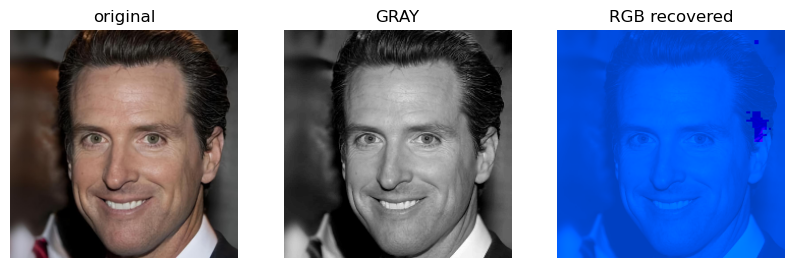

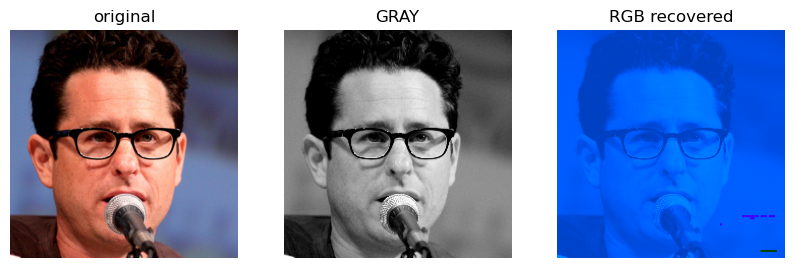

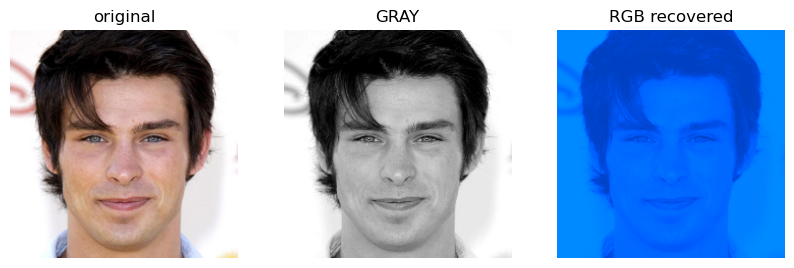

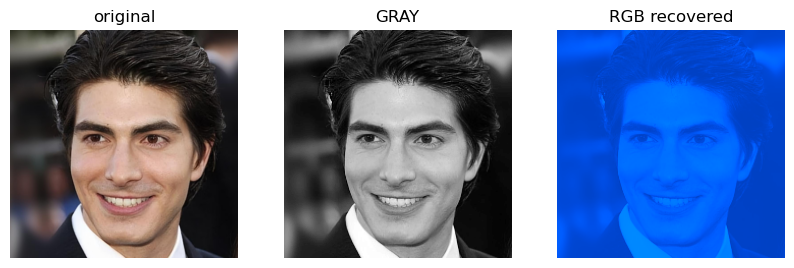

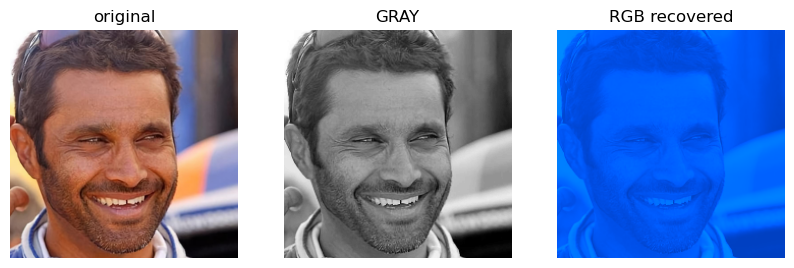

In [234]:
from imutils import paths
imagePaths = sorted(list(paths.list_images(r"datasets/celeba_hq/test/male"))[:5])
for imagePath in imagePaths:
    predict(imagePath)

Задание №2. Реализуйте автоэнкодер для удаления шума на однотипных изображениях

In [239]:
def add_noise(image, noise_factor=0.5):
    # Ensure the image is in float format with values in [0, 1]
    normalized_image = image / 255.0
    # Add noise
    noisy_array = normalized_image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    # Clip values to [0, 1] and rescale back to [0, 255]
    noisy_array = np.clip(noisy_array, 0.0, 1.0) * 255
    # Return as uint8
    return noisy_array.astype(np.uint8)

source_image_path = 'datasets/clean'
noisy_image_path = 'datasets/noisy'

os.makedirs(f"{source_image_path}/male", exist_ok=True)
os.makedirs(f"{noisy_image_path}/male", exist_ok=True)

base_image_path = 'datasets/celeba_hq/train/male'
for image in list_images(base_image_path):
    img = cv2.imread(image)
    img = cv2.resize(img, (224, 224))
    noisy_img = add_noise(img)
    cv2.imwrite(os.path.join(source_image_path, 'male', os.path.basename(image)), img)
    cv2.imwrite(os.path.join(noisy_image_path, 'male', os.path.basename(image)), noisy_img)

In [240]:
def preprocess_data(source, target):
    source = preprocess_input(source)
    
    source = source.astype('float32') / 255.0
    target = target.astype('float32') / 255.0
    
    return (source, target)

In [241]:
def trainGenerator(train_img_path, train_target_path):   
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        color_mode='rgb',
        target_size=(224, 224),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    target_datagen = ImageDataGenerator(**img_data_gen_args)
    target_generator = target_datagen.flow_from_directory(
        train_target_path,
        color_mode='rgb',
        target_size=(224, 224),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, target_generator)
    
    for (img, target) in train_generator:
        processed_img, processed_target = preprocess_data(img, target)
        yield (processed_img, processed_target)

In [242]:
encoder = VGG16(
    input_shape=(224, 224, 3),
    include_top=False
)
encoder.trainable = False

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(Conv2DTranspose(1024, (3, 3), strides=2, activation="relu", padding="same"))
autoencoder.add(Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same"))
autoencoder.add(Conv2DTranspose(256, (3, 3), strides=2, activation="relu", padding="same"))
autoencoder.add(Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same"))
autoencoder.add(Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same"))
autoencoder.add(Conv2DTranspose(3, (2, 2), activation='relu', padding='same'))

autoencoder.summary()
autoencoder.compile(optimizer=Adamax(0.001), loss='mse', metrics=['accuracy'])

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 1024)     4719616   
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 512)      4719104   
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 56, 56, 256)      1179904   
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 112, 112, 128)    295040    
 ranspose)                                           

In [243]:
trainGen = trainGenerator(
    noisy_image_path,
    source_image_path
)

batch_count = len(list(list_images(source_img_path))) // batch_size
print(f'Batches per epoch: {batch_count}')

Batches per epoch: 45


In [244]:
history = autoencoder.fit(
    trainGen,
    steps_per_epoch=batch_count,
    batch_size=batch_size,
    epochs=50,
)

Found 4500 images belonging to 1 classes.
Found 4500 images belonging to 1 classes.
Epoch 1/50
45/45 [==============================] - 16s 246ms/step - loss: 0.1599 - accuracy: 0.6065
Epoch 2/50
45/45 [==============================] - 11s 246ms/step - loss: 0.0709 - accuracy: 0.7579
Epoch 3/50
45/45 [==============================] - 11s 244ms/step - loss: 0.0536 - accuracy: 0.7772
Epoch 4/50
45/45 [==============================] - 11s 239ms/step - loss: 0.0456 - accuracy: 0.7778
Epoch 5/50
45/45 [==============================] - 11s 239ms/step - loss: 0.0418 - accuracy: 0.7783
Epoch 6/50
45/45 [==============================] - 11s 246ms/step - loss: 0.0397 - accuracy: 0.7789
Epoch 7/50
45/45 [==============================] - 11s 246ms/step - loss: 0.0381 - accuracy: 0.7791
Epoch 8/50
45/45 [==============================] - 11s 245ms/step - loss: 0.0368 - accuracy: 0.7791
Epoch 9/50
45/45 [==============================] - 11s 243ms/step - loss: 0.0359 - accuracy: 0.7784
Epoch 1

In [245]:
autoencoder.save('models/denoising.h5')

In [246]:
def predict(imagePath, autoencoder):
    noisy_image = cv2.imread(imagePath)
    noisy_image_prep = noisy_image / 256.0
    noisy_image_prep = np.reshape(noisy_image_prep, (1, 224, 224, 3))
    cleaned_img = autoencoder.predict(noisy_image_prep)
    plt.figure()
    
    orig_plt = plt.subplot(1, 2, 1)
    orig_plt.imshow(cv2.cvtColor(noisy_image, cv2.COLOR_BGR2RGB))
    orig_plt.set_title("Noisy image")
    orig_plt.axis("off")
    
    rgb_plt = plt.subplot(1, 2, 2)
    rgb_plt.imshow(cleaned_img[0])
    rgb_plt.set_title("Cleaned image")
    rgb_plt.axis("off")

In [247]:
autoencoder = models.load_model('models/denoising.h5')

1/1 [==============================] - 0s 371ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 15ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


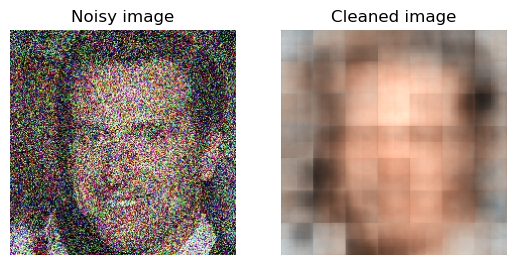

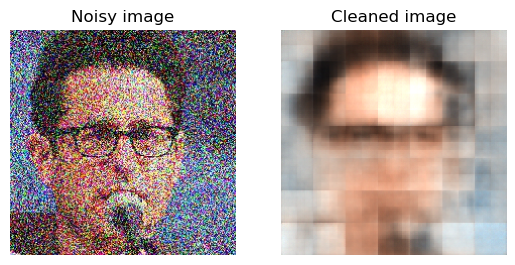

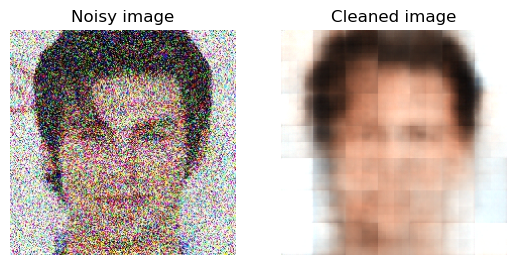

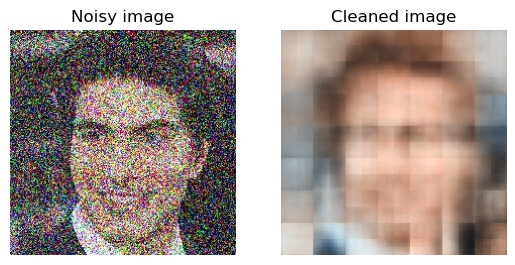

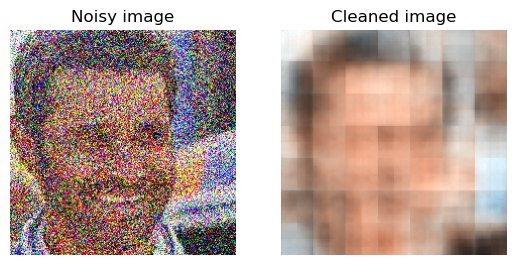

In [250]:
imagePaths = sorted(list(list_images(r"datasets/celeba_hq/test/male"))[:5])
os.makedirs('datasets/celeba_hq/test/noisy', exist_ok=True)
for imagePath in imagePaths:
    img = cv2.imread(imagePath)
    img = cv2.resize(img, (224, 224))
    noisy_img = add_noise(img)
    cv2.imwrite('datasets/celeba_hq/test/noisy/' + os.path.basename(imagePath), noisy_img)
    predict('datasets/celeba_hq/test/noisy/' + os.path.basename(imagePath), autoencoder)

Задание №.3 Реализуйте автоэнкодер для улучшения качества изображения путём увеличения его разрешения

In [251]:
seed=24
batch_size=20

train_dataset_path = 'datasets/celeba_hq/train'
val_dataset_path = 'datasets/celeba_hq/val'

In [252]:
def preprocess_data(source, target):
    source = preprocess_input(source)
    
    source = source.astype('float32') / 255.0
    target = target.astype('float32') / 255.0
    
    return (source, target)

In [253]:
def trainGenerator(train_path):   
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True)
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        color_mode='rgb',
        target_size=(256, 256),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    target_datagen = ImageDataGenerator(**img_data_gen_args)
    target_generator = target_datagen.flow_from_directory(
        train_path,
        color_mode='rgb',
        target_size=(512, 512),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, target_generator)
    
    for (img, target) in train_generator:
        processed_img, processed_target = preprocess_data(img, target)
        yield (processed_img, processed_target)

In [254]:
train_gen = trainGenerator(train_dataset_path)
val_gen = trainGenerator(val_dataset_path)

train_steps_count = len(list(list_images(train_dataset_path))) // batch_size
val_steps_count = len(list(list_images(val_dataset_path))) // batch_size
print(f'Train steps per epoch: {train_steps_count}')
print(f'Val steps per epoch: {val_steps_count}')

Train steps per epoch: 225
Val steps per epoch: 50


In [255]:
from tensorflow.keras.layers import Input, Conv2D, UpSampling2D, BatchNormalization

encoder = VGG16(
    input_shape=(256, 256, 3),
    include_top=False
)
encoder.trainable = False

autoencoder = Sequential()
autoencoder.add(encoder)
autoencoder.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((4, 4)))
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((4, 4)))
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
autoencoder.add(UpSampling2D((4, 4)))
autoencoder.add(BatchNormalization())
autoencoder.add(Conv2D(3, (3, 3), activation='relu', padding='same'))

autoencoder.summary()
autoencoder.compile(optimizer=Adamax(0.001), loss='mse', metrics=['accuracy'])

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d_105 (Conv2D)         (None, 8, 8, 256)         1179904   
                                                                 
 up_sampling2d_45 (UpSamplin  (None, 32, 32, 256)      0         
 g2D)                                                            
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 256)      1024      
 ormalization)                                                   
                                                                 
 conv2d_106 (Conv2D)         (None, 32, 32, 64)        147520    
                                                                 
 up_sampling2d_46 (UpSamplin  (None, 128, 128, 64)   

In [256]:
history = autoencoder.fit(
    train_gen,
    steps_per_epoch=train_steps_count,
    epochs=30, 
    validation_steps=val_steps_count,
    validation_data=val_gen,
)

Found 4500 images belonging to 1 classes.
Found 4500 images belonging to 1 classes.
Epoch 1/30
225/225 [==============================] - ETA: 0s - loss: 0.0881 - accuracy: 0.6333Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
225/225 [==============================] - 84s 368ms/step - loss: 0.0881 - accuracy: 0.6333 - val_loss: 0.0602 - val_accuracy: 0.6255
Epoch 2/30
225/225 [==============================] - 81s 362ms/step - loss: 0.0508 - accuracy: 0.6901 - val_loss: 0.0443 - val_accuracy: 0.7009
Epoch 3/30
225/225 [==============================] - 81s 360ms/step - loss: 0.0427 - accuracy: 0.7116 - val_loss: 0.0379 - val_accuracy: 0.7193
Epoch 4/30
225/225 [==============================] - 81s 359ms/step - loss: 0.0395 - accuracy: 0.7248 - val_loss: 0.0362 - val_accuracy: 0.7361
Epoch 5/30
225/225 [==============================] - 81s 360ms/step - loss: 0.0366 - accuracy: 0.7325 - val_loss: 0.0350 - val_accuracy: 0.7373
Epoch 6/30
225/225 [===

In [257]:
autoencoder.save('models/super_resolution.h5')

In [258]:
autoencoder = models.load_model('models/super_resolution.h5')

In [259]:
def predict(imagePath, autoencoder):
    watermark = cv2.imread(imagePath)
    watermark_prep = watermark / 256.0
    watermark_prep = np.reshape(watermark_prep, (1, 256, 256, 3))
    cleaned_img = autoencoder.predict(watermark_prep)
    cleaned_img = np.absolute(cleaned_img)
    plt.figure()
    
    orig_plt = plt.subplot(1, 2, 1)
    orig_plt.imshow(cv2.cvtColor(watermark, cv2.COLOR_BGR2RGB))
    orig_plt.set_title("Original")
    orig_plt.axis("off")
    rgb_plt = plt.subplot(1, 2, 2)
    rgb_plt.imshow(cleaned_img[0])
    rgb_plt.set_title("Upscale")
    rgb_plt.axis("off")

1/1 [==============================] - 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 25ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 14ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 13ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


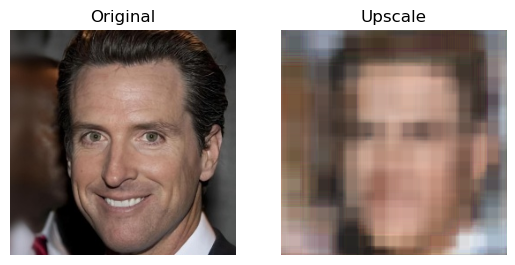

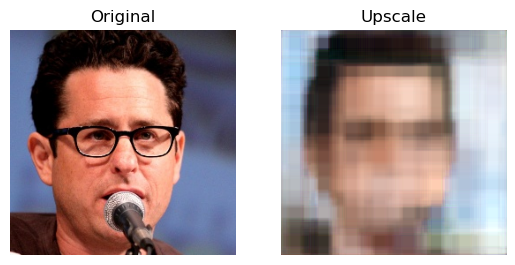

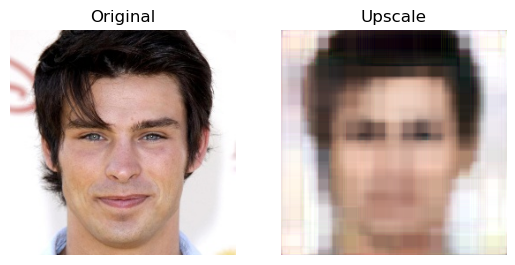

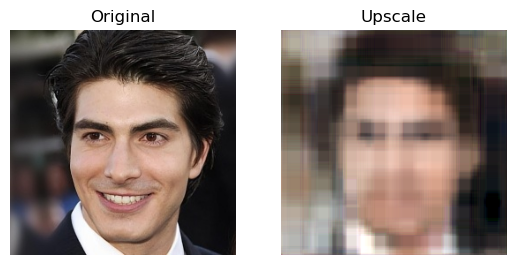

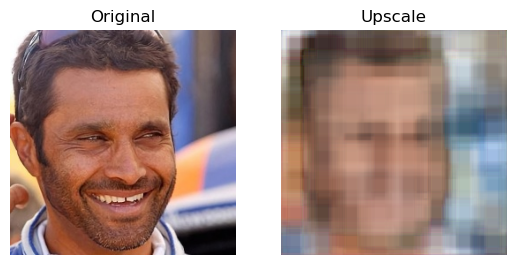

In [260]:
imagePaths = sorted(list(list_images(r"datasets/celeba_hq/test/male"))[:5])
for imagePath in imagePaths:
    img = cv2.imread(imagePath)
    img = cv2.resize(img, (256, 256))
    cv2.imwrite('datasets/celeba_hq/test/super_resolution/' + os.path.basename(imagePath), img)
    predict('datasets/celeba_hq/test/super_resolution/' + os.path.basename(imagePath), autoencoder)